In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:% !important; }</style>"))

In [1]:
import statistics
from binance.spot import Spot as Client
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
from binance.lib.utils import config_logging
from binance.error import ClientError
import time

In [2]:
def recupero_dati(valuta, limite):
    spot_client = Client(base_url="https://api.binance.com")
    data = spot_client.klines(valuta, "1m", limit=limite)
    df = pd.DataFrame(data)
    df[0] = (pd.to_datetime(df[0],unit='ms'))
    df = df.drop(columns=[6, 7, 8, 9, 10, 11])
    df.columns = ['data', 'apertura', 'massimo', 'minimo', 'chiusura', 'volume']
    df["chiusura"] = df["chiusura"].astype(float)
    return df

In [3]:
dati = recupero_dati("BTCUSDT",100)

In [8]:
def doppia_media_mobile(dati, window_short, window_long):
    segnali = pd.DataFrame(index=dati.index)
    segnali['segnali'] = 0.0
    segnali['chiusura'] = dati['chiusura']
    segnali['media mobile corta'] = dati['chiusura'].rolling(window=window_short,min_periods=1, center=False).mean()
    segnali['media mobile lunga'] = dati['chiusura'].rolling(window=window_long,min_periods=1, center=False).mean()
    segnali['segnali'][window_short:] = np.where(segnali['media mobile corta'][window_short:] > segnali['media mobile lunga'][window_short:], 1.0, 0.0)
    segnali['ordini'] = segnali['segnali'].diff()
    return segnali

In [9]:
mm=doppia_media_mobile(dati,5, 10)

In [10]:
def grafico(dati):
    fig = plt.figure(figsize=(15, 15), dpi=80)
    ax1 = fig.add_subplot(111, ylabel='Valuta in $')
    dati['chiusura'].plot(ax=ax1, color='g', lw=2., legend=True)
    dati['media mobile corta'].plot(ax=ax1, color='r', lw=2., legend=True)
    dati['media mobile lunga'].plot(ax=ax1, color='b', lw=2., legend=True)
    ax1.plot(dati.loc[dati.ordini== 1.0].index, dati["chiusura"][dati.ordini == 1.0], '^', markersize=7, color='k')
    ax1.plot(dati.loc[dati.ordini== -1.0].index, dati["chiusura"][dati.ordini == -1.0], 'v', markersize=7, color='k')
    plt.legend(["Chiusura","Media mobile corta","Media mobile lunga","Compra", "Vende"])
    plt.title("Doppia SMA")
    plt.show()

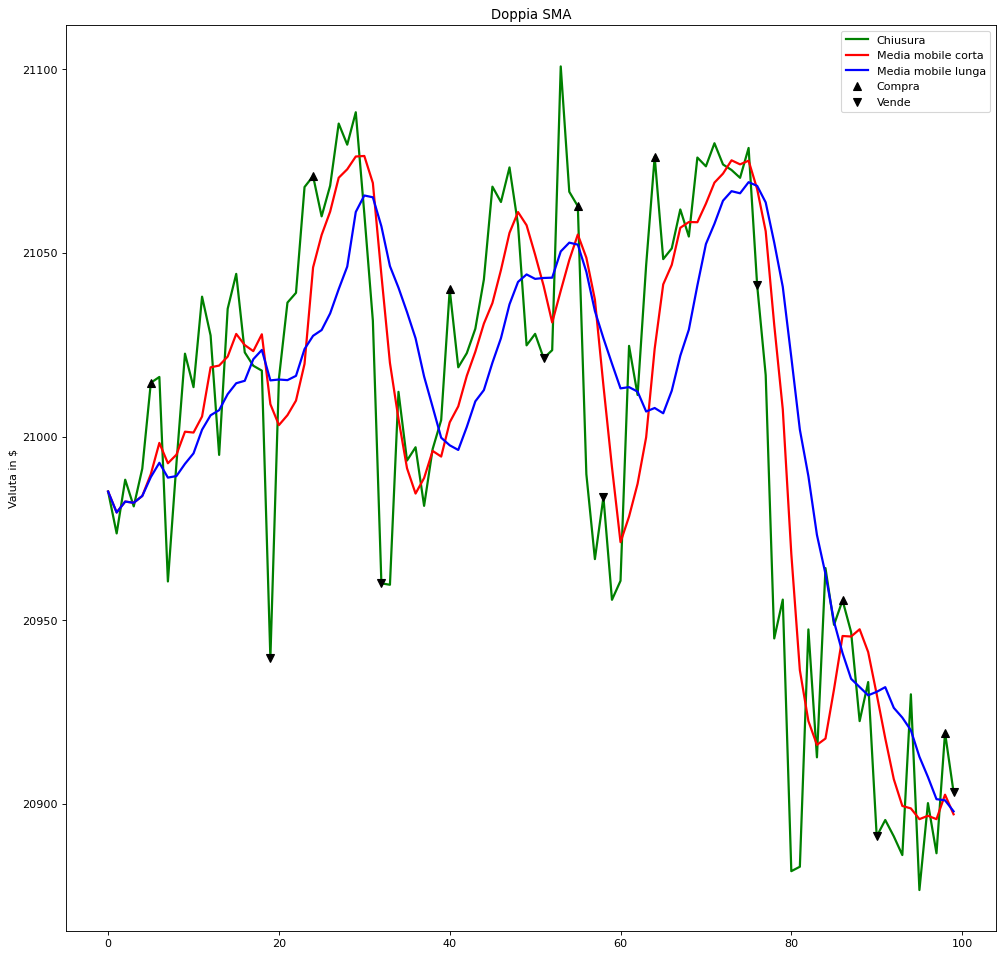

In [11]:
grafico(mm)

In [ ]:
##  def prezzo_aggiornato(dati):
##  spot_client = Client(base_url="https://testnet.binance.vision")
##  btcusdt_raw = spot_client.ticker_price("BTCUSDT")
##  prezzo = pd.DataFrame(btcusdt_raw,index=[0])
##  prezzo.columns = ['ticker', 'chiusura']
##  prezzo_agg=pd.concat([dati, prezzo])
##  prezzo_aggiornato(mm)
##  prezzo1=prezzo_aggiornato(dati)

In [ ]:
config_logging(logging, logging.DEBUG)

key = ""
secret = ""

compra = {
    "symbol": "BTCUSDT",
    "side": "BUY",
    "type": "LIMIT",
    "timeInForce": "GTC",
    "quantity": 0.002,
    "price": 9050,
}

vendi = {
    "symbol": "BTCUSDT",
    "side": "SELL",
    "type": "LIMIT",
    "timeInForce": "GTC",
    "quantity": 0.002,
    "price": 1500,
}

client = Client(key, secret, base_url="https://testnet.binance.vision")

# client.exchange_info()
client.exchange_info(symbol="BTCUSDT")
# client.account(recvWindow=6000)

def compra_vendi(dati):
  if dati['ordini'].iat[-1] ==1:
    client.new_order(**compra)
  elif dati['ordini'].iat[-1] ==-1:
    client.new_order(**vendi)

In [ ]:
# mm.loc[99,'ordini']=1
# compra_vendi(mm)

In [ ]:
for scambi in range(0,10):
  dati = recupero_dati("BTCUSDT",100)
  mm=doppia_media_mobile(dati,5, 10)
  time.sleep(10)